In [3]:
import nibabel as nib

### Task 1: Load the Data

In [4]:
fmri_file = "data/func.nii.gz"

In [5]:
f_img = nib.load(fmri_file)

In [6]:
f_img

### Task 2: Visualize a voxel

In [31]:
f_data = f_img.get_fdata()

In [32]:
import matplotlib.pyplot as plt
import numpy as np

selected_voxel = f_data[39, 39, 21, :]

In [33]:
selected_voxel.shape

(50,)

### Task 3: Periodogram of Voxel Frequencies

In [14]:
from scipy.signal import periodogram

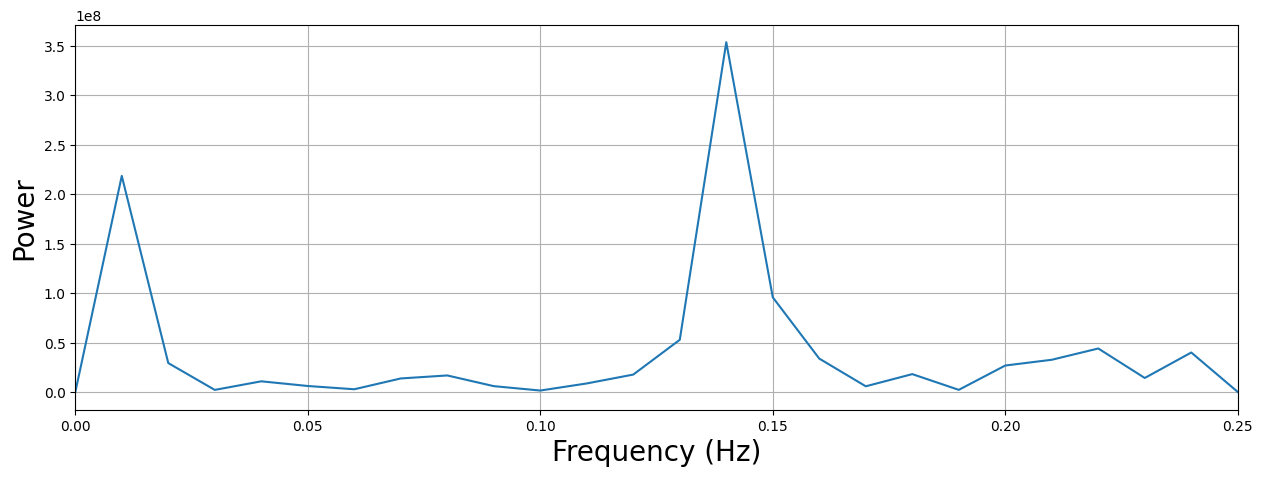

In [41]:
# Set sampling frequency
TR = 2
sampling_frequency = 1/TR # it takes two seconds to get one image

freqs, pows = periodogram(selected_voxel, fs=sampling_frequency)
plt.figure(figsize=(15, 5))
plt.plot(freqs, pows)
plt.xlim(0, 0.25)
plt.ylabel('Power', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.grid()
plt.show()

### Task 4: Make a Model

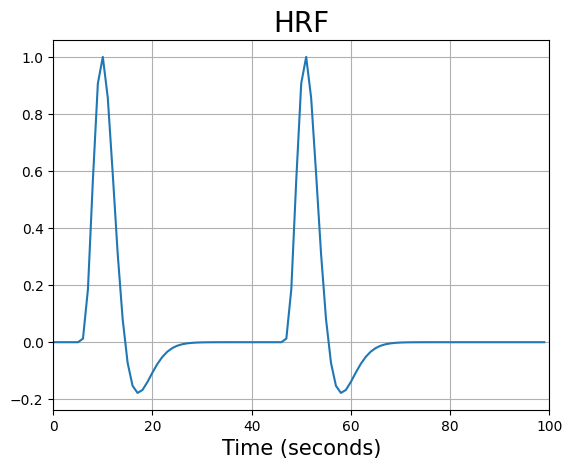

In [59]:
predictor = np.zeros(100) 
predictor[[4,45]] = 1
predictor

# convolve
TR = 2
osf = 2
length_hrf = 32  # sec

from nilearn.glm.first_level.hemodynamic_models import glover_hrf

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
convolved_pred = np.convolve(predictor, canonical_hrf, 'full')
convolved_pred = convolved_pred[:predictor.size]

from scipy.interpolate import interp1d

original_scale = np.arange(0, 100, 1)  # from 0 to 100 seconds
resampler = interp1d(original_scale, convolved_pred)
desired_scale = np.arange(0, 100, 2)
predictor_ds = resampler(desired_scale)

plt.plot(convolved_pred)
plt.title('HRF', fontsize=20)
plt.xlim(0, 100)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

In [64]:
intercept = np.ones((predictor_ds.size))
X_conv = np.stack((intercept, predictor_ds), axis=1)

In [69]:
X_conv

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.25419423e-02],
       [ 1.00000000e+00,  5.69350935e-01],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  5.90016018e-01],
       [ 1.00000000e+00,  8.07846760e-02],
       [ 1.00000000e+00, -1.52831783e-01],
       [ 1.00000000e+00, -1.67385311e-01],
       [ 1.00000000e+00, -1.06556141e-01],
       [ 1.00000000e+00, -5.15626930e-02],
       [ 1.00000000e+00, -2.06785714e-02],
       [ 1.00000000e+00, -7.18777035e-03],
       [ 1.00000000e+00, -2.22807895e-03],
       [ 1.00000000e+00, -6.28404698e-04],
       [ 1.00000000e+00, -1.63686048e-04],
       [ 1.00000000e+00, -3.98348382e-05],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.

### Task 5: Make and Estimate a GLM for the Model

In [70]:
#Solving the regrsssion
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ y

#Calculate predicted signal from model with convolution
y_hat_conv = X_conv @ betas_conv

#Calculate predicted signal from the simple model (estimted above)
y_hat_simple = X_simple @ betas_simple


plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(y_hat_conv, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(y_hat_simple, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'y' is not defined